# Red Inicial


## Imports


In [172]:
from collections import deque
from enum import Enum
from functools import cache
from random import random
from time import perf_counter, time
from typing import Generator, Optional

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from gymnasium.spaces import Box, Dict, Discrete
from gymnasium.utils import seeding
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

## Clases y Funciones


In [173]:
class Packet_Generator():
    def __init__(self, min_ip=0, max_ip=2000,
                 min_port=0, max_port=4000,
                 min_protocol=0, max_protocol=100,
                 min_size=15, max_size=40,
                 min_rate=0, max_rate=4):

        self.packet = Dict({
            "IP":  Box(low=min_ip, high=max_ip, shape=(), dtype=int),
            "PORT":  Box(low=min_port, high=max_port, shape=(), dtype=int),
            "PROTOCOL":  Box(low=min_protocol, high=max_protocol, shape=(), dtype=int),
            "SIZE":  Box(low=min_size, high=max_size, shape=(), dtype=int)
        })
        self.min_rate: int = min_rate
        self.max_rate: int = max_rate

    def generate_packet(self):
        return self.packet.sample()

    def generate_packets(self):
        num_packets: int = np.random.randint(self.min_rate, self.max_rate)
        return [self.generate_packet() for _ in range(num_packets)]


class DOS_Packet_Generator(Packet_Generator):
    def __init__(self,
                 min_ip=0, max_ip=2000,
                 min_port=0, max_port=4000,
                 min_protocol=0, max_protocol=100,
                 min_size=20, max_size=50,
                 min_rate=2, max_rate=8):

        ip: int = np.random.randint(min_ip, max_ip)
        super().__init__(ip, ip,
                         min_port, max_port,
                         min_protocol, max_protocol,
                         min_size, max_size,
                         min_rate, max_rate)


class DDOS_Packet_Generator(Packet_Generator):
    def __init__(self,
                 min_ip=0, max_ip=2000,
                 min_port=0, max_port=4000,
                 min_protocol=0, max_protocol=100,
                 min_size=5, max_size=15,
                 min_rate=2, max_rate=10):
        raise NotImplementedError("DDOS Packet Generator not implemented")
        super().__init__(min_ip, max_ip,
                         min_port, max_port,
                         min_protocol, max_protocol,
                         min_size, max_size,
                         min_rate, max_rate)


class PacketAttack(Enum):
    @staticmethod
    def new_set(description, weight, class_ref):
        return {
            "Description": description,
            "weight": weight,
            "class": class_ref
        }

    @staticmethod
    def not_implemented():
        raise NotImplementedError(f"Class not implemented")

    @classmethod
    @cache
    def weights(cls):
        attack_weights = []
        for attack in PacketAttack:
            attack_weights.append(attack.value["weight"])
        return np.array(attack_weights)

    # ----ENUM VALUES----
    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)
    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)


dos_gen = DOS_Packet_Generator()

print(dos_gen.generate_packets())

[{'IP': 406, 'PORT': 1647, 'PROTOCOL': 16, 'SIZE': 47}, {'IP': 406, 'PORT': 2028, 'PROTOCOL': 0, 'SIZE': 38}, {'IP': 406, 'PORT': 2339, 'PROTOCOL': 95, 'SIZE': 38}, {'IP': 406, 'PORT': 96, 'PROTOCOL': 9, 'SIZE': 33}, {'IP': 406, 'PORT': 334, 'PROTOCOL': 84, 'SIZE': 33}, {'IP': 406, 'PORT': 2350, 'PROTOCOL': 19, 'SIZE': 44}, {'IP': 406, 'PORT': 232, 'PROTOCOL': 18, 'SIZE': 20}]


In [174]:
from time import perf_counter
tiempo_global: float = 0.0
iteraciones = 0
# Decaorador auxiliar para poder medir el tiempo de las funciones

def medir_tiempo(activado=False):
    def fun(funcion):
        def wrapper(*args, **kwargs):
            if not activado:
                return funcion(*args, **kwargs)
            fun_tiempo = perf_counter
            inicio: float = fun_tiempo()
            resultado = funcion(*args, **kwargs)
            tiempo_total: float = fun_tiempo() - inicio
            global tiempo_global, iteraciones
            medida = 1e6
            t: float = tiempo_total*medida
            tiempo_global += t
            iteraciones += 1
            print(f"Tiempo de ejecución de {
                funcion.__name__}: {t:.2f} micro-segundos")
            return resultado
        return wrapper
    return fun


In [175]:
class Acciones(Enum):
    PERMITIR = 2
    DENEGAR = -2

    @classmethod
    def int_to_action(cls, action: int) -> "Acciones":
        return cls._get_actions_list()[action]

    @classmethod
    @cache
    def _get_actions_list(cls) -> list["Acciones"]:
        return list(Acciones)

    @classmethod
    @cache
    def action_to_int(cls, action: "Acciones") -> int:
        return cls._get_actions_list().index(action)


class RouterEnv(gym.Env):
    total_time: float = 10.0  # En uds

    def __init__(self, max_len=20, seed: Optional[int] = None):

        super(RouterEnv, self).__init__()
        if max_len < 1:
            raise ValueError("max_len must be greater than 0")

        self.max_len: int = max_len
        self.rate = 5  # bytes por segundo de procesamiento
        self.attack_probability = 0.5
        self.ocupacion_media = 0.75

        self._set_initial_values(seed)

        self.observation_space = Box(low=0, high=1000, shape=(
            # Paquetes en la cola
            len(self.calculate_queue_stats()),), dtype=np.float32)

        self.action_space = Discrete(len(Acciones))

    def _set_initial_values(self, seed):
        self.queue = deque(maxlen=self.max_len)
        # self.step_durations: list[float] = []
        self._np_random, self._np_random_seed = seeding.np_random(seed)
        self.current_action: Acciones = Acciones.PERMITIR
        self.action_count: int = 0
        self.uds_tiempo_pasado: float = 0.0
        self.mb_restantes: float = -1.0

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        self._set_initial_values(seed)

        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def _get_obs(self):
        stats = self.calculate_queue_stats()
        return stats

    def _get_info(self):
        npack, tam_total, ocu_act, *_ = self.calculate_queue_stats()
        return {"Stats": {
            "Queue": np.array(self.queue),
            "AttackProb": self.attack_probability,
            "NumPaquetes": npack,
            "TamañoTotal": tam_total,
            "Action": self.current_action,
            "OcupacionActual": ocu_act,
            "LimiteOcupación": self.ocupacion_media
        }}

    def calculate_queue_stats(self):
        tam_total = 0
        for paquete in self.queue:
            tam_total += int(paquete["SIZE"])
        tam_promedio: float = tam_total / \
            len(self.queue) if len(self.queue) > 0 else 0.0

        num_packets: int = len(self.queue)
        ocu_act: float = self.get_ocupacion()
        return np.array([num_packets, tam_promedio, ocu_act,
                         Acciones.action_to_int(self.current_action), self.action_count], dtype=np.float32)

    def packet_input(self, input: list[dict[str, any]] = None) -> int:
        if input is not None:
            paquetes = input
        else:
            prob: float = self.np_random.random()
            if prob > self.attack_probability:
                # Generación de paquetes normales
                paquetes = Packet_Generator().generate_packets()
            else:
                # Generación de paquetes maliciosos
                paquetes = DOS_Packet_Generator().generate_packets()

        if len(self.queue) + len(paquetes) > self.max_len:
            debug_queue = len(self.queue)

            espacio_libre = self.max_len - len(self.queue)
            self.queue.extend(paquetes[:espacio_libre])

            assert len(self.queue) == self.max_len
            assert len(paquetes)+debug_queue - \
                len(self.queue) == len(paquetes) - (espacio_libre)

            return len(paquetes) - (espacio_libre)
        self.queue.extend(paquetes)
        return 0  # No se han descartado paquetes

    @medir_tiempo(0)
    def step(self, action_num: int):

        # Suponiendo que el paso es de 10 microsegundos:

        action: Acciones = Acciones.int_to_action(action_num)
        if action == self.current_action:
            self.action_count += 1
        else:
            self.action_count = 0

        self.current_action = action

        if self.current_action == Acciones.PERMITIR:
            descartados: int = self.packet_input()
        else:
            descartados: int = 0

        self.procesar_por_tamaño()

        reward: float = self.get_reward(descartados, action)
        observation = self._get_obs()
        # True si se desvía del comportamiento normal para abortar, necesitaría un reset
        truncated = False
        info = self._get_info()

        self.uds_tiempo_pasado += 1
        finished: bool = self._is_finished_execution()

        return observation, reward, finished, truncated, info

    def get_ocupacion(self) -> float:
        return len(self.queue) / self.max_len

    def get_reward(self, descartados, action: Acciones) -> float:

        reward = 1

        actual: float = self.get_ocupacion()
        if actual > self.ocupacion_media:
            np.square(np.subtract(actual, self.ocupacion_media))
            penalizacion_ocupacion: float = np.square(
                np.subtract(actual, self.ocupacion_media))*100

            if reward > 0:
                reward -= penalizacion_ocupacion
            else:
                reward += penalizacion_ocupacion

        penalizacion_descartados = 0.5
        reward -= descartados*penalizacion_descartados

        if action.value >= 0:
            reward += action.value  # recompensa si la acción tiene recompensa positiva
        else:
            # penalizar si la acción tiene recompensa negativa y se repite varias veces
            reward += action.value*self.action_count

        return reward

    @medir_tiempo(0)
    def procesar_por_tamaño(self):

        if len(self.queue) == 0:
            return

        # print(self.queue)
        tam_procesado = 0.0
        # Calcula los mb que faltan por procesar

        if self.mb_restantes == -1 and len(self.queue) > 0:
            paquete = self.queue[0]
            self.mb_restantes = paquete["SIZE"]

        while tam_procesado < self.rate and len(self.queue) > 0:
            if self.mb_restantes == 0:
                p2 = self.queue.popleft()  # Quita el paquete que se ha procesado
                if len(self.queue) == 0:
                    self.mb_restantes == -1
                    break
                # Nuevo paquete
                paquete = self.queue[0]
                assert p2 != paquete
                # Calcula los mb que faltan por procesar
                self.mb_restantes = paquete["SIZE"]
            else:
                # Procesar
                procesado_local: float = min(self.mb_restantes,  # Procesar lo que queda del paquete
                                             self.rate-tam_procesado)  # Procesar lo que queda del paso
                self.mb_restantes -= procesado_local
                tam_procesado += procesado_local

    def _is_finished_execution(self) -> bool:
        # Terminar solo después de 10 pasos
        return self.uds_tiempo_pasado >= self.total_time

    def close(self):
        # Cerrar el entorno, liberar recursos, cerrar conexiones, etc
        return super().close()

    def render(self, mode='human'):
        # Renderizar el entorno
        return super().render(mode=mode)

In [176]:
env = RouterEnv(seed=1)
check_env(env)

model:PPO = PPO("MlpPolicy", env, verbose=True)

model.learn(total_timesteps=10)
model.save("Example")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 7.58     |
| time/              |          |
|    fps             | 487      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------


In [177]:
print(f"Tiempo medio: {tiempo_global/iteraciones if abs(iteraciones)>1e-5 else 0:.2f} micro-segundos de {iteraciones} iteraciones")

Tiempo medio: 0.00 micro-segundos de 0 iteraciones


## Comprobación funcionamiento

In [178]:
seed=1
env = RouterEnv(seed=seed)
model = PPO.load("Example")

num_steps = 5
obs, _ = env.reset()
# Variables de información:
acciones = []
rewards=[]
ocu = []
tams=[]
num=[]
lim_ocu=0
a2=[]

#-------------------------

_states = None
for episode in range(num_steps):

    done = False
    step_counter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, terminated, info = env.step(action)
        print(info)


        ocu.append(info["Stats"]["OcupacionActual"])
        lim_ocu=info["Stats"]["LimiteOcupación"]
        tams.append(info["Stats"]["TamañoTotal"])
        num.append(info["Stats"]["NumPaquetes"])
        a2.append(info["Stats"]["Action"])
        
        rewards.append(reward)
        acciones.append(action.item())
        
        done: bool = done or terminated
        
    env.reset(seed=seed)
    step_counter += 1

# Debug
print(f"Acciones: {acciones}")
print(list(map(lambda x: Acciones.int_to_action(x), acciones)))
print(list(map(lambda x: int(round(x,0)), rewards)))
print(a2)


{'Stats': {'Queue': array([{'IP': 1647, 'PORT': 169, 'PROTOCOL': 82, 'SIZE': 32},
       {'IP': 1647, 'PORT': 3259, 'PROTOCOL': 40, 'SIZE': 29},
       {'IP': 1647, 'PORT': 979, 'PROTOCOL': 24, 'SIZE': 26}],
      dtype=object), 'AttackProb': 0.5, 'NumPaquetes': 3.0, 'TamañoTotal': 29.0, 'Action': <Acciones.PERMITIR: 2>, 'OcupacionActual': 0.15, 'LimiteOcupación': 0.75}}
{'Stats': {'Queue': array([{'IP': 1647, 'PORT': 169, 'PROTOCOL': 82, 'SIZE': 32},
       {'IP': 1647, 'PORT': 3259, 'PROTOCOL': 40, 'SIZE': 29},
       {'IP': 1647, 'PORT': 979, 'PROTOCOL': 24, 'SIZE': 26},
       {'IP': 315, 'PORT': 1327, 'PROTOCOL': 80, 'SIZE': 32},
       {'IP': 315, 'PORT': 1084, 'PROTOCOL': 9, 'SIZE': 39},
       {'IP': 315, 'PORT': 1754, 'PROTOCOL': 79, 'SIZE': 31},
       {'IP': 315, 'PORT': 422, 'PROTOCOL': 63, 'SIZE': 33},
       {'IP': 315, 'PORT': 2057, 'PROTOCOL': 31, 'SIZE': 50}],
      dtype=object), 'AttackProb': 0.5, 'NumPaquetes': 8.0, 'TamañoTotal': 34.0, 'Action': <Acciones.PERMITIR:

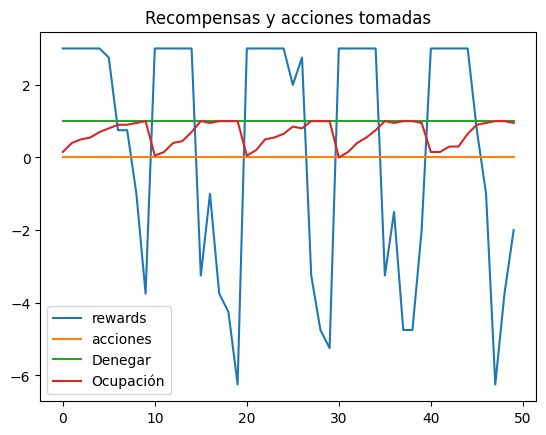

[3.0, 3.0, 3.0, 3.0, 3.0, 2.7499999999999996, 0.7499999999999996, 0.7499999999999996, -0.9999999999999982, -3.75, 3.0, 3.0, 3.0, 3.0, 3.0, -3.25, -0.9999999999999982, -3.75, -4.25, -6.25, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0000000000000004, 2.7499999999999996, -3.25, -4.75, -5.25, 3.0, 3.0, 3.0, 3.0, 3.0, -3.25, -1.4999999999999982, -4.75, -4.75, -1.9999999999999982, 3.0, 3.0, 3.0, 3.0, 3.0, 0.7499999999999996, -0.9999999999999982, -6.25, -3.75, -1.9999999999999982]
0 50  0.0 1.0


In [179]:
assert len(acciones) == len(rewards)
plt.plot(rewards, label="rewards")
plt.plot(acciones, label="acciones")

plt.plot([Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar")
plt.plot(ocu, label="Ocupación")
plt.title("Recompensas y acciones tomadas")

plt.legend()
plt.show()
print(rewards)
num_permitidos=acciones.count(1)
print(num_permitidos,len(acciones)-num_permitidos,"",num_permitidos/len(acciones),1-num_permitidos/len(acciones))

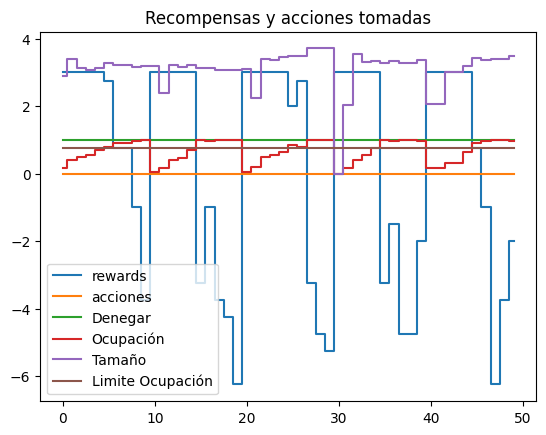

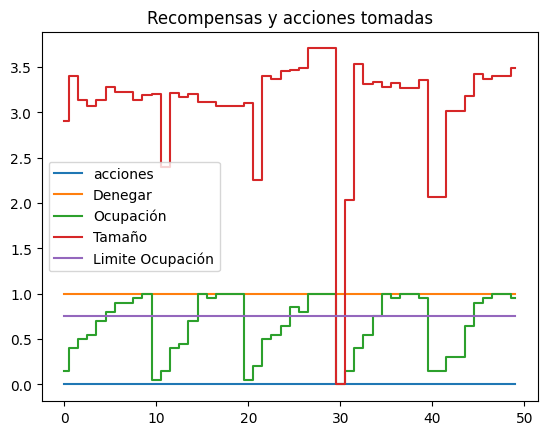

In [180]:


plt.step(range(len(rewards)), rewards, label="rewards", where='mid')
plt.step(range(len(acciones)), acciones, label="acciones", where='mid')
plt.step(range(len(acciones)), [Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar", where='mid')
plt.step(range(len(ocu)),ocu, label="Ocupación",where='mid')

tam=[x/10 for x in tams]
plt.step(range(len(tams)),tam, label="Tamaño",where='mid')

plt.plot([lim_ocu]*len(ocu), label="Limite Ocupación")


plt.title("Recompensas y acciones tomadas")
plt.legend()
plt.show()


plt.step(range(len(acciones)), acciones, label="acciones", where='mid')
plt.step(range(len(acciones)), [Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar", where='mid')
plt.step(range(len(ocu)),ocu, label="Ocupación",where='mid')
plt.step(range(len(tams)),tam, label="Tamaño",where='mid')

plt.plot([lim_ocu]*len(ocu), label="Limite Ocupación")

plt.title("Recompensas y acciones tomadas")
plt.legend()
plt.show()

In [181]:
print(Acciones.action_to_int(Acciones.PERMITIR))
print(Acciones.action_to_int(Acciones.DENEGAR))

0
1
